# Fast Food Marketing Campaign A\B Test

A fast-food chain plans to add a new item to its menu and test three potential marketing campaigns for promotion. \
To determine which campaign has the greatest impact on sales, the new item will be introduced at various randomly selected locations, 
with each location implementing one of the three different promotions. 

The weekly sales of the new item will be recorded at each location over the first four weeks. 

- This constitutes an A/B test - or, more accurately, an A/B/C test - to determine whether there is a difference among them and, if so, which promotion performs best and should be retained.

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro,levene
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway
from scikit_posthocs import posthoc_dunn
from scipy.stats import kruskal
from rich import console
import scipy.stats as stats
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

cons = console.Console()

plt.rcParams['font.family'] = 'Times New Roman'

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
size=20
params = {'legend.fontsize': 'large',
        'figure.figsize': (12,8),
        'axes.labelsize': size,
        'axes.titlesize': size,
        'xtick.labelsize': size*0.75,
        'ytick.labelsize': size*0.75,
        'axes.titlepad': 25}
plt.rcParams.update(params)

In [10]:
df = pd.read_csv('WA_Marketing-Campaign.csv')
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


**Column explanation**:

- **MarketID**: unique identifier for market
- **MarketSize**: size of market area by sales
- **LocationID**: unique identifier for store location
- **AgeOfStore**: age of store in years
- **Promotion**: one of three promotions that were tested
- **week**: one of four weeks when the promotions were run
- **SalesInThousands**: sales amount for a specific *LocationID*, *Promotion*, and *week*

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


### Exploratory Data Analysis

In [12]:
if df.isnull().values.any():
    print("Missing values found")
else:
    print("No missing values found")
if df.duplicated().any():
    print("Duplicates found")
else:
    print("No duplicates found")

No missing values found
No duplicates found


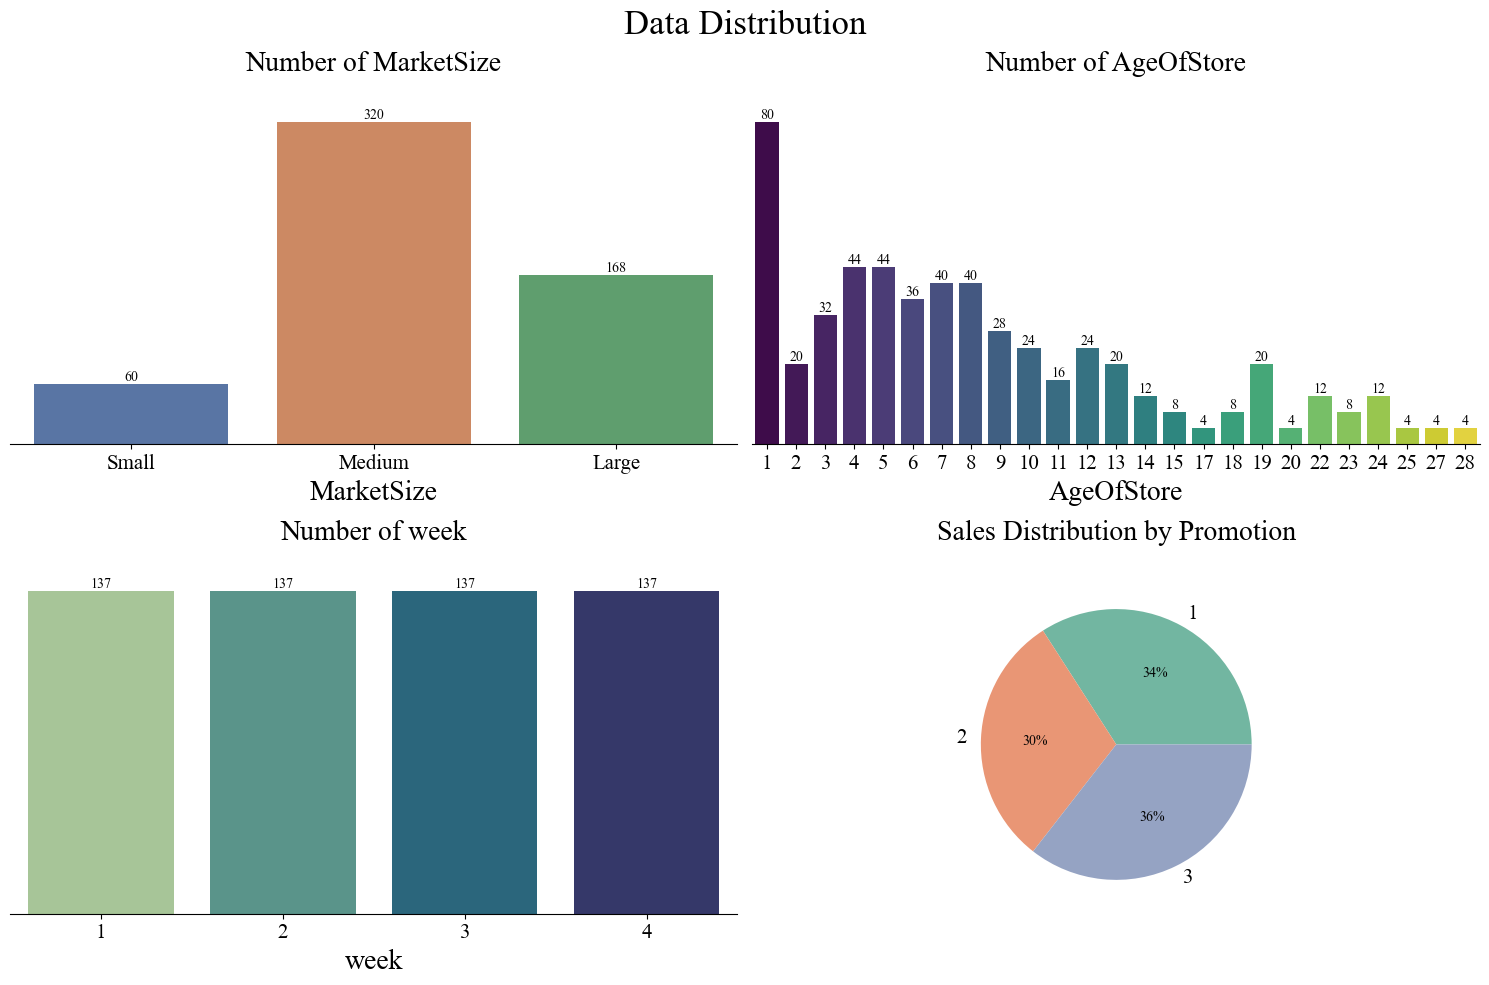

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

cols = ['MarketSize', 'AgeOfStore', 'week']
categories = ['Small', 'Medium', 'Large']
colors = ['deep', 'viridis', 'crest']

c = 0
for i in range(2):  
    for j in range(2): 
        if c < len(cols):
            if cols[c] == 'MarketSize':
                sns.countplot(data=df, x=cols[c], order=categories, ax=ax[i, j], palette=colors[c], legend=False)
            else:
                sns.countplot(data=df, x=cols[c], hue=cols[c], ax=ax[i, j], palette=colors[c], legend=False)
            ax[i, j].set_title('Number of ' + cols[c])
            ax[i, j].spines[['top', 'right', 'left']].set_visible(False)
            ax[i, j].set_yticks([])
            ax[i, j].xaxis.set_ticks_position('bottom')
            ax[i, j].set_ylabel('')
            ax[i, j].set_facecolor('white')
            for p in ax[i, j].patches:
                ax[i, j].annotate(format(p.get_height(), '.0f'), 
                                (p.get_x() + p.get_width() / 2., p.get_height()), 
                                ha='center', va='center', 
                                xytext=(0, 5), 
                                textcoords='offset points')
            c += 1

df.groupby('Promotion').sum()['SalesInThousands'].plot.pie(ax=ax[1, 1], 
                                                        autopct='%1.0f%%', 
                                                        colors=['#72b6a1', '#e99675', '#95a3c3'])
ax[1, 1].set_title('Sales Distribution by Promotion')  
ax[1, 1].set_ylabel('') 

plt.suptitle('Data Distribution', fontsize=25)

plt.tight_layout()
plt.show()

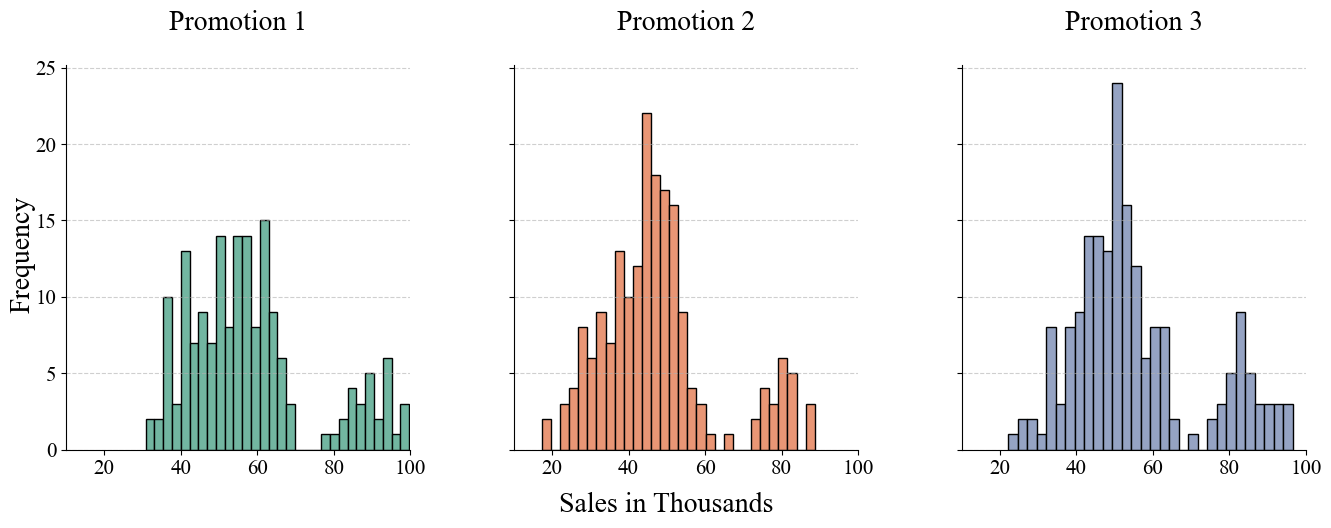

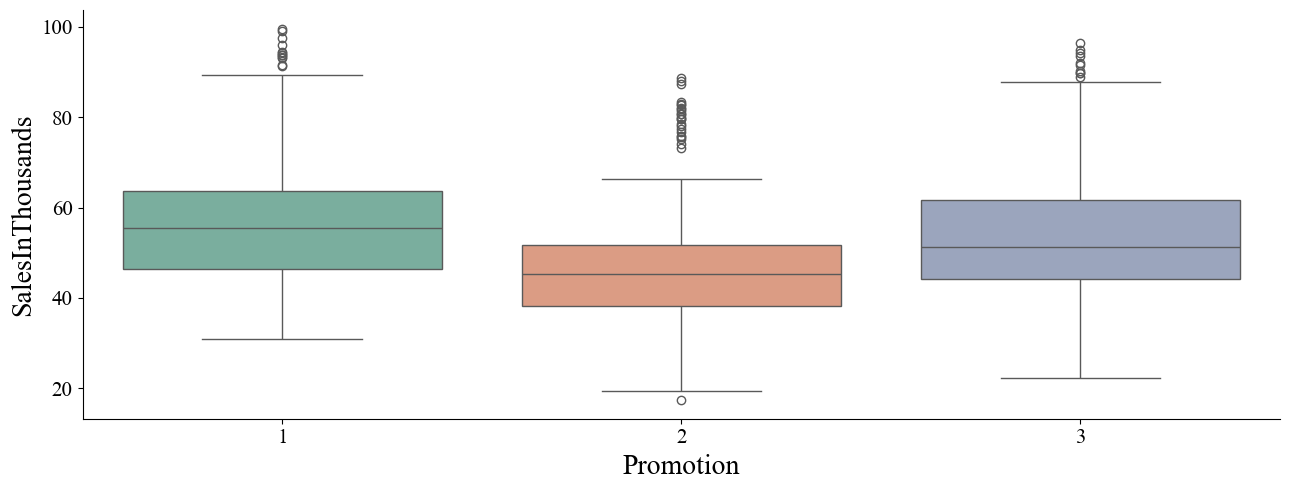

In [14]:
# Distribution of Sales by Promotion
custom_palette = ['#72b6a1', '#e99675', '#95a3c3']

f, ax = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for i in range(3):
    df[df['Promotion'] == i+1].hist('SalesInThousands', bins=30, ax=ax[i], color=custom_palette[i], edgecolor='black')
    ax[i].set_title('Promotion ' + str(i+1))
    ax[i].grid(False)
    ax[i].grid(axis='y', linestyle='--', alpha=0.6)
    ax[i].spines[['top', 'right']].set_visible(False)
    ax[i].xaxis.set_tick_params(bottom=True, top=False) 
    ax[i].yaxis.set_tick_params(left=True, right=False)
    ax[i].set_xlim(10, 100)

f.text(0.5, -0.015, 'Sales in Thousands', ha='center', fontsize=20)
f.text(0.09, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=20)

plt.figure(figsize=(13, 5))
sns.boxplot(data=df, x='Promotion', y='SalesInThousands', palette=custom_palette)
sns.despine()
plt.tick_params(axis='x', bottom=True, top=False)
plt.tick_params(axis='y', left=True, right=False)
plt.tight_layout()
plt.show()

In [15]:
df.groupby('Promotion')["SalesInThousands"].describe()

,count,mean,std,min,25%,50%,75%,max
Promotion,,,,,,,,
1,172.0,58.099012,16.553782,30.81,46.3525,55.385,63.6175,99.65
2,188.0,47.329415,15.108955,17.34,38.1700,45.385,51.7450,88.64
3,188.0,55.364468,16.766231,22.18,44.1975,51.165,61.7325,96.48


In [16]:
def remove_outliers(dataframe, col_name):
    cleaned_data = pd.DataFrame()
    
    for promo_type in dataframe['Promotion'].unique():
        df_p = dataframe[dataframe['Promotion'] == promo_type]
        
        quartile1 = np.percentile(df_p[col_name], 25)
        quartile3 = np.percentile(df_p[col_name], 75)
        
        interquantile_range = quartile3 - quartile1
        
        up_limit = quartile3 + 1.5 * interquantile_range
        low_limit = quartile1 - 1.5 * interquantile_range
        
        cleaned_data = pd.concat([cleaned_data, df_p[(df_p[col_name] >= low_limit) & (df_p[col_name] <= up_limit)]])
    return cleaned_data

cleaned_data = remove_outliers(df, 'SalesInThousands')

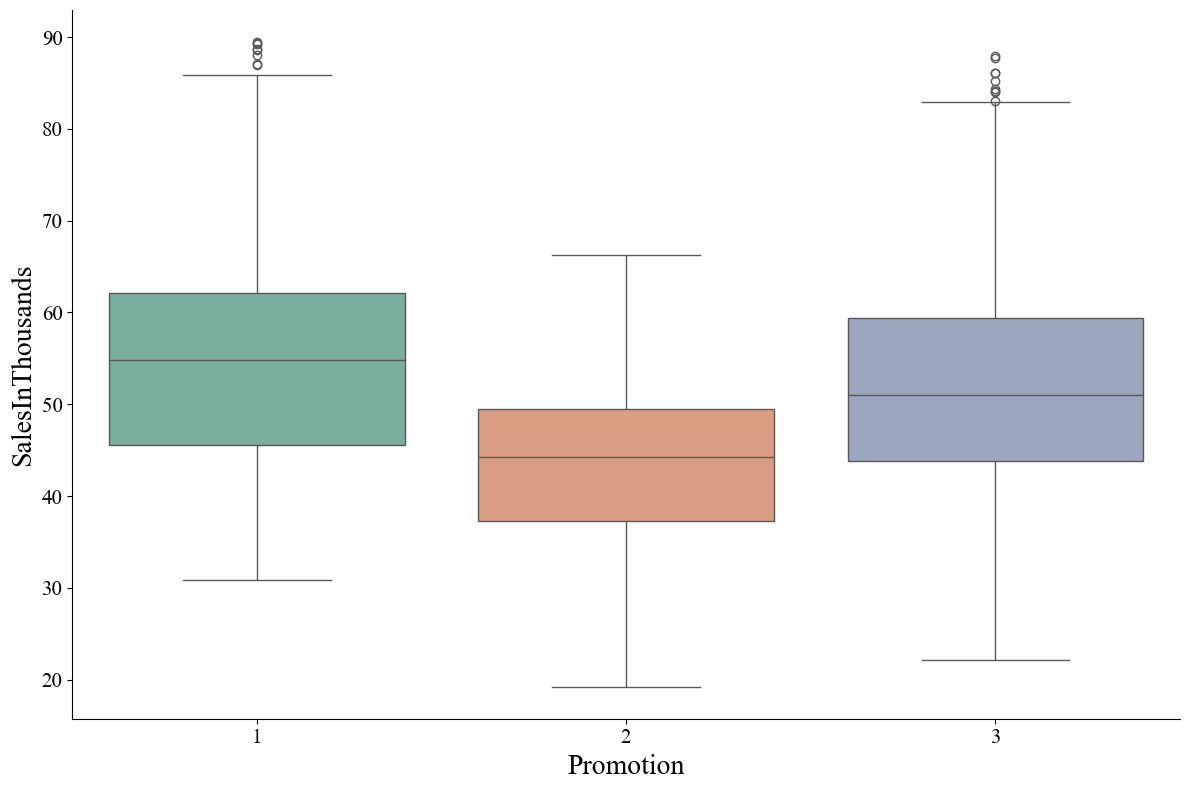

In [17]:
# plot the boxplot for the cleaned data
plt.figure()

sns.boxplot(data=cleaned_data, x='Promotion', y='SalesInThousands', palette=custom_palette)
sns.despine()
plt.tick_params(axis='x', bottom=True, top=False)
plt.tick_params(axis='y', left=True, right=False)
plt.tight_layout()
plt.show()

In [18]:
# Table of key information
counts = cleaned_data['Promotion'].value_counts().to_frame()

proportions = cleaned_data['Promotion'].value_counts(normalize=True).to_frame()
proportions *= 100
proportions = proportions.round(1)

Proportion_of_promotion = counts.join(proportions)
Proportion_of_promotion.columns = ['Sample Size', 'Proportion (%)']
Proportion_of_promotion.sort_index(inplace=True)

treatment_effect = cleaned_data.groupby('Promotion')['SalesInThousands'].mean() - cleaned_data.groupby('Promotion')['SalesInThousands'].mean().min()
treatment_effect = treatment_effect.apply(lambda x: 'Baseline' if x == 0.00 else x)
Proportion_of_promotion['Average Sales'] = cleaned_data.groupby('Promotion')['SalesInThousands'].mean().values
Proportion_of_promotion['Relative effect compared to Prom 2'] = treatment_effect.values
Proportion_of_promotion

,Sample Size,Proportion (%),Average Sales,Relative effect compared to Prom 2
Promotion,,,,
1,160,31.9,55.345187,12.43909
2,164,32.7,42.906098,Baseline
3,178,35.5,53.297978,10.39188


> **Key Points**:
>
> - ***Sample Size***: The total number of sales for promotions 1, 2, and 3 are 160, 164, and 178, respectively.
> - ***Variant Proportions***: After removing the outliers, the proportions of observations in each group have changed. The new proportions for promotions 1, 2, and 3 are 31.9%, 32.7%, and 35.5%, respectively.


Promotion,1,2,3
MarketID,,,
1,20.0,20.0,12.0
2,4.0,NaN,20.0
3,28.0,24.0,36.0
4,16.0,16.0,4.0
5,8.0,32.0,20.0
6,20.0,24.0,16.0
7,16.0,16.0,28.0
8,20.0,8.0,20.0
9,12.0,8.0,20.0


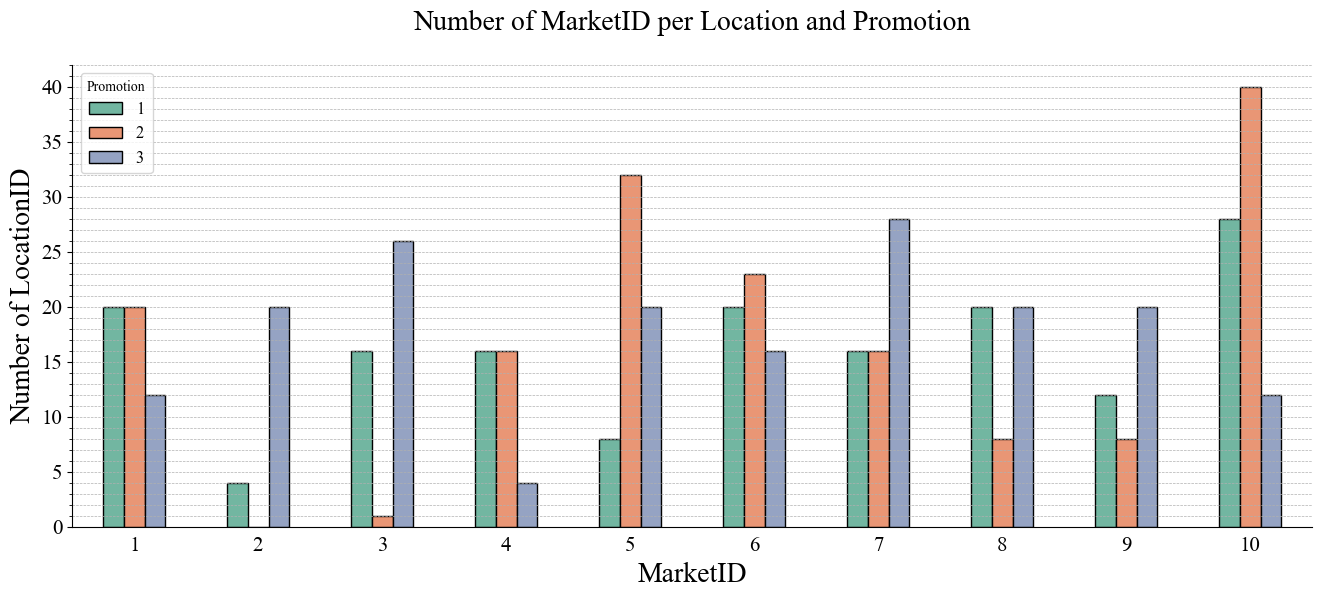

In [19]:
# Table of distribution of promotion across all markets and locations
cleaned_data.groupby(['MarketID', 'Promotion'])['LocationID'].size().unstack().plot(kind='bar', figsize=(16, 6), color=custom_palette, edgecolor='black')

display(df.groupby(['MarketID', 'Promotion'])['LocationID'].size().unstack())

plt.title('Number of MarketID per Location and Promotion')
plt.ylabel('Number of LocationID')
plt.minorticks_on()
plt.grid(axis='y', which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='x', which='both', top=False, bottom=False)
plt.tick_params(axis='y', which='both', right=False)
plt.gca().spines[['top','right']].set_visible(False)
plt.xticks(rotation=0)
plt.show()

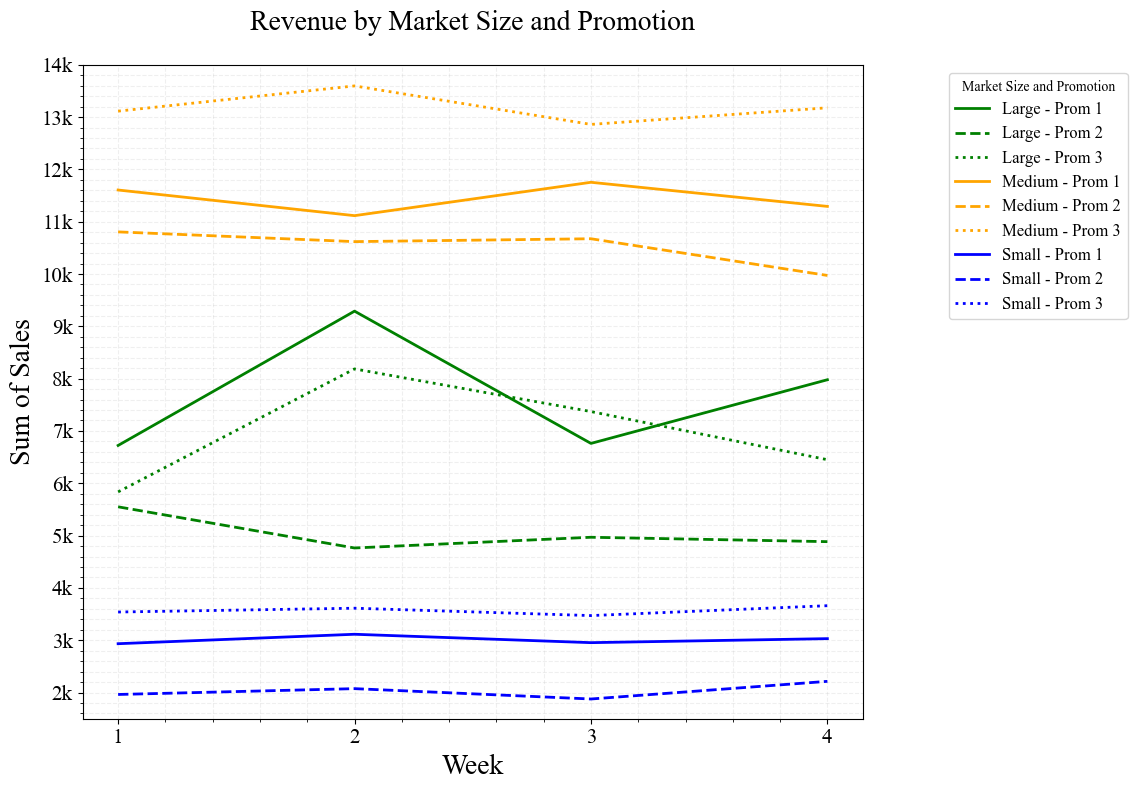

In [20]:
# Weekly sales distribution
tmp = cleaned_data.groupby(['week', 'Promotion', 'MarketSize']).agg({'SalesInThousands': ['count', 'sum', 'mean', 'median']}).reset_index()
tmp['Promotion'] = tmp['Promotion'].astype(str)
tmp['MarketSize'] = tmp['MarketSize'].astype(str)
tmp['MarketSize_Promotion'] = tmp['MarketSize'] + ' - ' + tmp['Promotion']

plt.figure()

palette = {'Small': 'blue', 'Medium': 'orange', 'Large': 'green'}
line_styles = {'1': 'solid', '2': 'dashed', '3': 'dotted'}

for market_size in tmp['MarketSize'].unique():
    for promotion in tmp['Promotion'].unique():
        subset = tmp[(tmp['MarketSize'] == market_size) & (tmp['Promotion'] == promotion)]
        sns.lineplot(x='week', y=('SalesInThousands', 'sum'), data=subset, 
                    color=palette[market_size], linestyle=line_styles[promotion], lw=2,
                    label=f'{market_size} - Prom {promotion}')

plt.title('Revenue by Market Size and Promotion')
plt.ylabel('Sum of Sales')
plt.yticks(np.arange(0, 2001, 100), [f'{i}k' for i in range(0, 21, 1)])
plt.xlabel('Week')
plt.ylim(150, 1400)
plt.xticks([1, 2, 3, 4])
plt.legend(title='Market Size and Promotion', loc='upper right', bbox_to_anchor=(1.35, 1))
plt.grid(axis='both', which= 'both', linestyle='--', alpha=0.2)
plt.minorticks_on()
plt.tight_layout()
plt.show()

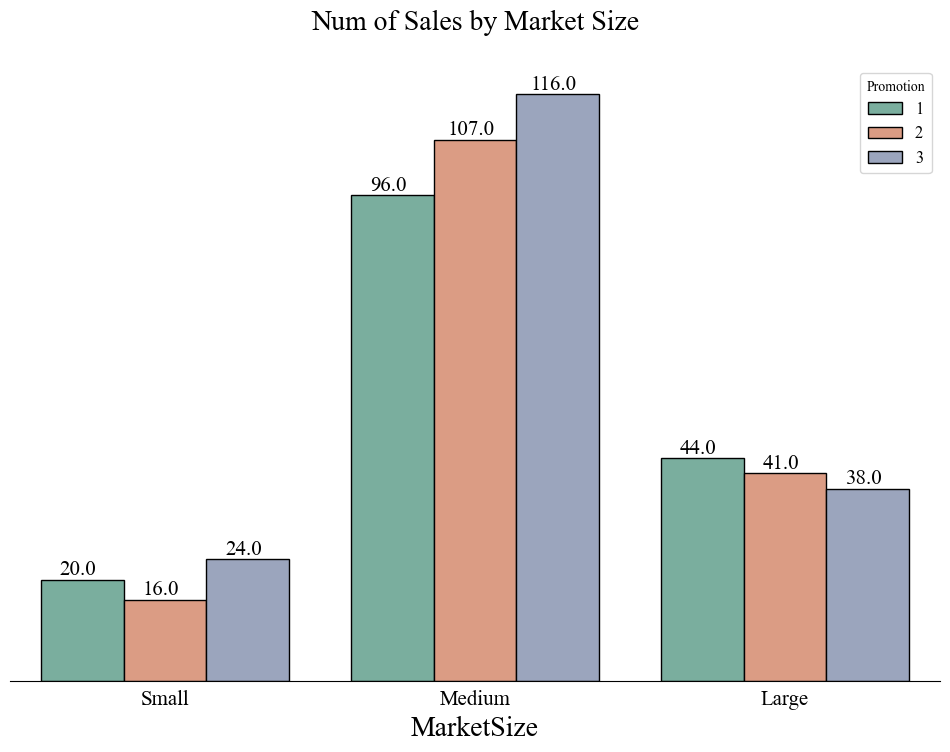

In [21]:
# Number of sales by Market Size
categories = ['Small', 'Medium', 'Large']

ax = sns.countplot(x=cleaned_data.MarketSize, hue=cleaned_data.Promotion, palette=custom_palette, order=categories, edgecolor='black')
ax.set_title('Num of Sales by Market Size')
for i in ax.patches:
    if i.get_height() > 0:
        ax.text(i.get_x()+0.12, i.get_height()+0.9, str(i.get_height()), fontsize=15, color='black', ha='center')
ax.grid(False)
ax.set_yticks([])
ax.set_ylabel('')
plt.tick_params(axis='x', which='both', top=False, bottom=False)
ax.spines[['top', 'right', 'left']].set_visible(False)

plt.show()

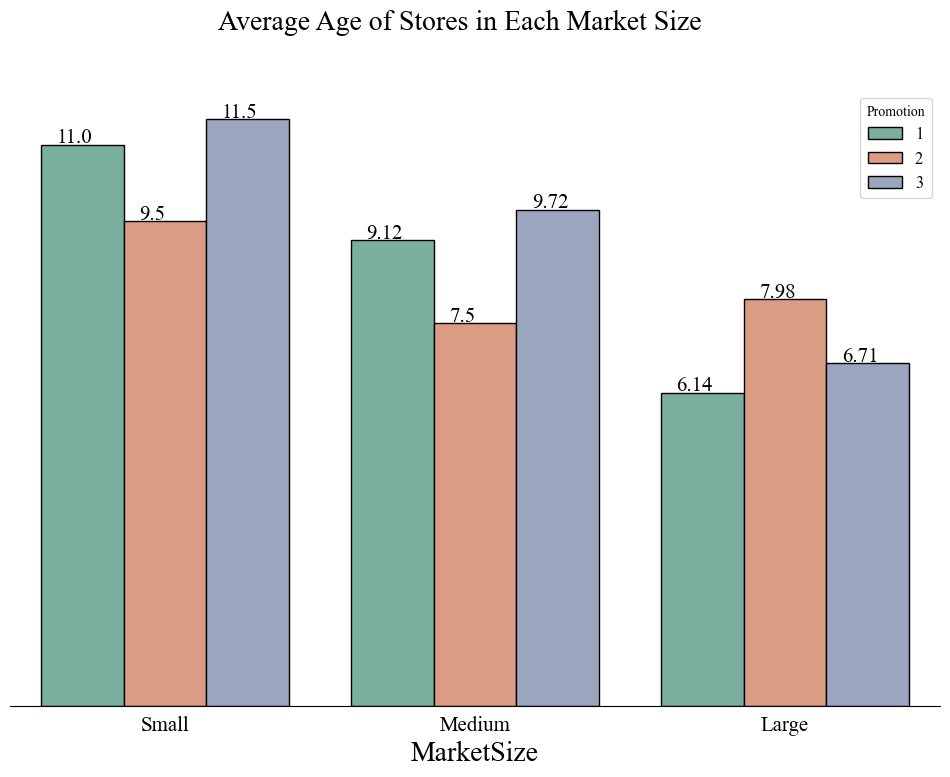

In [22]:
# Average sales by Market Size
tmp = cleaned_data.groupby(['Promotion','MarketSize']).agg({'AgeOfStore':['count','min','mean','median','max']}).reset_index(level=1).sort_values(['MarketSize'], ascending=False)
ax=sns.barplot(x=tmp['MarketSize'], y=tmp[('AgeOfStore','mean')], hue=tmp.index, palette=custom_palette, edgecolor='black')
ax.set_ylabel('Avg. Store Age')
plt.suptitle('Average Age of Stores in Each Market Size', fontsize=20)
sns.despine(left=True)
for i in ax.patches:
    if i.get_height() > 0:
        ax.text(i.get_x()+0.05, i.get_height()+0.03, str(round(i.get_height(),2)), fontsize=15, color='black')
plt.grid(False)
plt.tick_params(axis='x', which='both', top=False, bottom=False)
plt.ylabel('')
plt.yticks([])
plt.show()

### Statistical Tests for Comparing Promotions

To determine whether the differences between the groups (promotions) are significant, we need to perform statistical tests. The choice of test depends on the type of data being analyzed and the assumptions met.

In general, the goal of a marketing campaign is typically to increase sales, this is the most direct measure of success. Therefore, for this project, we will compare the performance of the different promotions in terms of sales (in thousands) using two approaches:

1. **Sales performance regardless of other parameters** (e.g., market size).
2. **Sales performance while accounting for market size** (small, medium, large).


#### 1. Assessing Data Normality
The first step is to evaluate whether the **SalesInThousands** data is normally distributed for each promotion type across markets and market sizes. This is critical because many statistical tests (e.g., ANOVA) rely on the assumption of normality.

**Steps for Normality Assessment**

- **Q-Q Plots**:
Visual inspection of Q-Q plots will provide a preliminary assessment of normality. If the data points \
closely follow the diagonal line in the Q-Q plot, it suggests that the sales data is approximately normally distributed.

    - **Interpretation**: Deviations from the diagonal line indicate departures from normality (e.g., \
    skewness or heavy tails), which may impact the validity of parametric statistical tests.  <br />
<br />
- **Shapiro-Wilk Test**:
This test provides a statistical method to evaluate the assumption of normality. A p-value > 0.05 indicates \
that the data does not significantly deviate from normality.

- **Levene's Test**:
This test evaluates the assumption of homogeneity of variances across groups, which is important for ANOVA. \
A p-value > 0.05 indicates that the variances are roughly equal across groups.

#### 1.1 Q-Q plot and Shapiro Test

Comparison all promotions across markets and for each market size (small, medium, large)

In [27]:
def normality_test(df, size='All'):
    f, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))
    index = 0
    for promotion in np.sort(df['Promotion'].unique()):
        data = df[df['Promotion'] == promotion]['SalesInThousands']
        print('Market size: ', size, '\nPromotion: ', promotion, '\nResults: ', shapiro(data))
        print('')
        qqplot(data, line='s', ax=ax[index])
        plt.suptitle(f'Market Size: {size}', fontsize=20, y=1.05)
        ax[index].set_title(f'Promotion {promotion}') 
        ax[index].grid(True)
        ax[index].set_axisbelow(True)
        ax[index].spines[['top', 'right']].set_visible(False)
        ax[index].set_facecolor('white')
        ax[index].set_xlabel('')
        ax[index].set_ylabel('')
        index += 1
    f.text(0.5, -0.05, 'Theoretical Quantiles', ha='center', fontsize=20)
    f.text(-0.01, 0.5, 'Sample Quantiles', va='center', rotation='vertical', fontsize=20)
    plt.tight_layout()
    plt.show()

Market size:  All 
Promotion:  1 
Results:  ShapiroResult(statistic=0.9375624656677246, pvalue=1.7683266833046218e-06)

Market size:  All 
Promotion:  2 
Results:  ShapiroResult(statistic=0.9788514971733093, pvalue=0.013023050501942635)

Market size:  All 
Promotion:  3 
Results:  ShapiroResult(statistic=0.9297983050346375, pvalue=1.3668353915363696e-07)



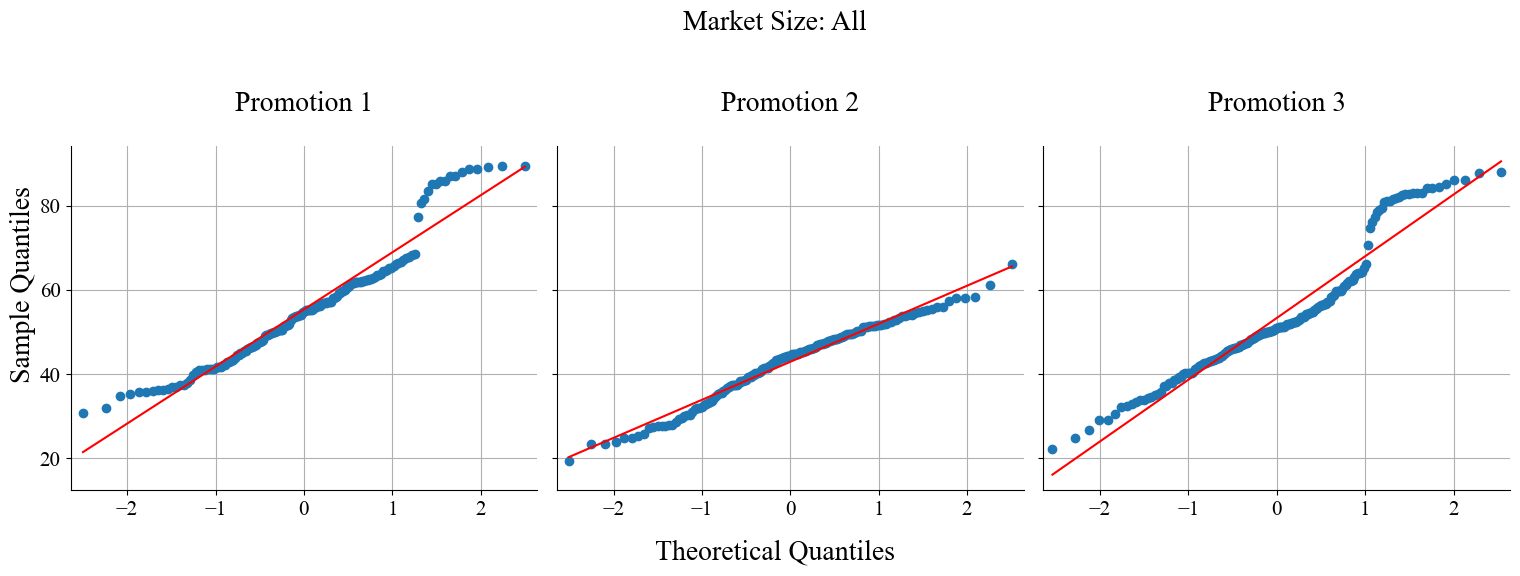

In [28]:
# Test for normality across all market regardless the size
normality_test(cleaned_data, 'All')

The Q-Q plot suggests a potential **deviation from normality** in the data. Additionally, the Shapiro-Wilk test produced a **p-value lower than 0.05**, \
leading to the **rejection of the null hypothesis of normality**. This indicates that the data likely deviates significantly from a normal distribution. 

Market size:  Large 
Promotion:  1 
Results:  ShapiroResult(statistic=0.8791671991348267, pvalue=0.0002645572239998728)

Market size:  Large 
Promotion:  2 
Results:  ShapiroResult(statistic=0.9517488479614258, pvalue=0.08062118291854858)

Market size:  Large 
Promotion:  3 
Results:  ShapiroResult(statistic=0.7819055914878845, pvalue=4.5681235860683955e-06)



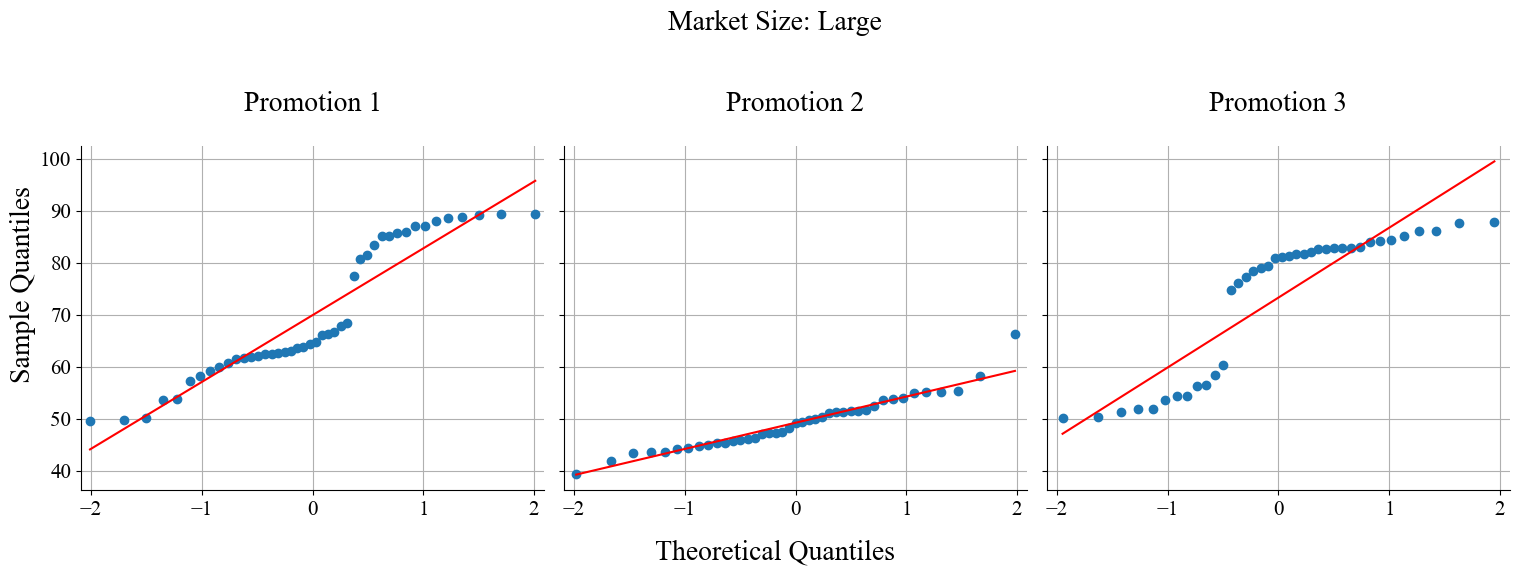

Market size:  Medium 
Promotion:  1 
Results:  ShapiroResult(statistic=0.9788880348205566, pvalue=0.1241278350353241)

Market size:  Medium 
Promotion:  2 
Results:  ShapiroResult(statistic=0.9864671230316162, pvalue=0.354552686214447)

Market size:  Medium 
Promotion:  3 
Results:  ShapiroResult(statistic=0.983024001121521, pvalue=0.1506854146718979)



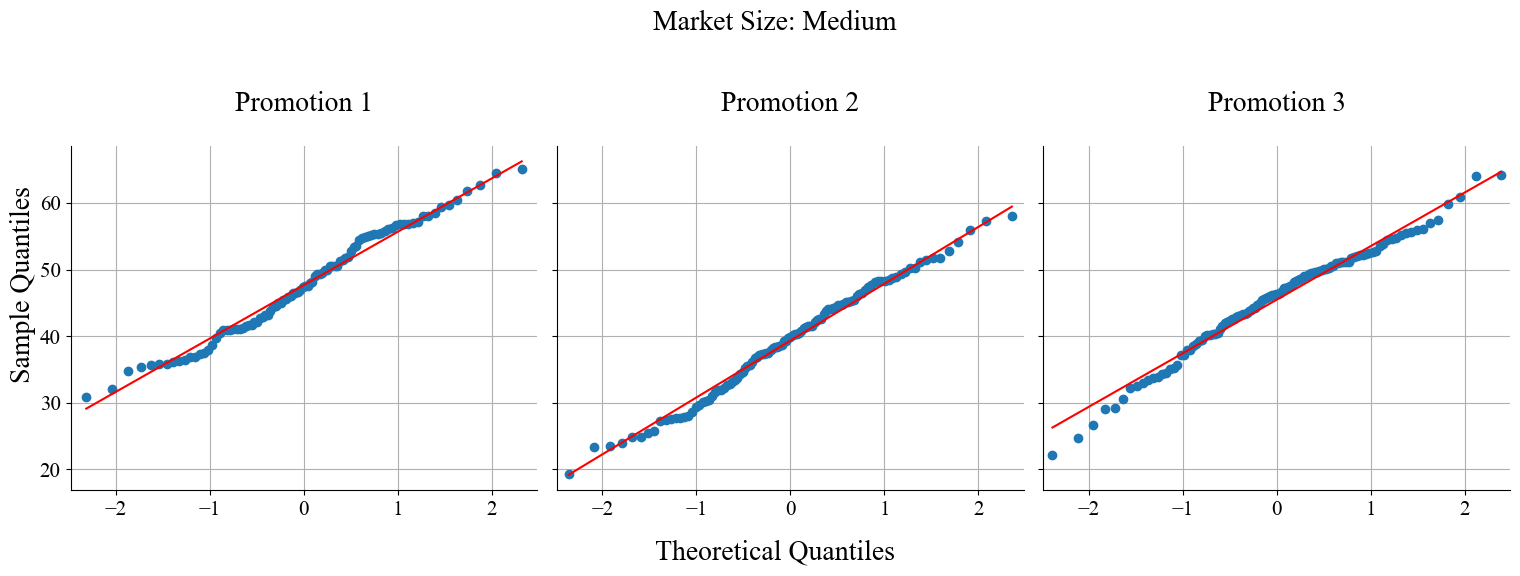

Market size:  Small 
Promotion:  1 
Results:  ShapiroResult(statistic=0.9466675519943237, pvalue=0.3193189203739166)

Market size:  Small 
Promotion:  2 
Results:  ShapiroResult(statistic=0.9612023830413818, pvalue=0.6836669445037842)

Market size:  Small 
Promotion:  3 
Results:  ShapiroResult(statistic=0.9816325306892395, pvalue=0.9239219427108765)



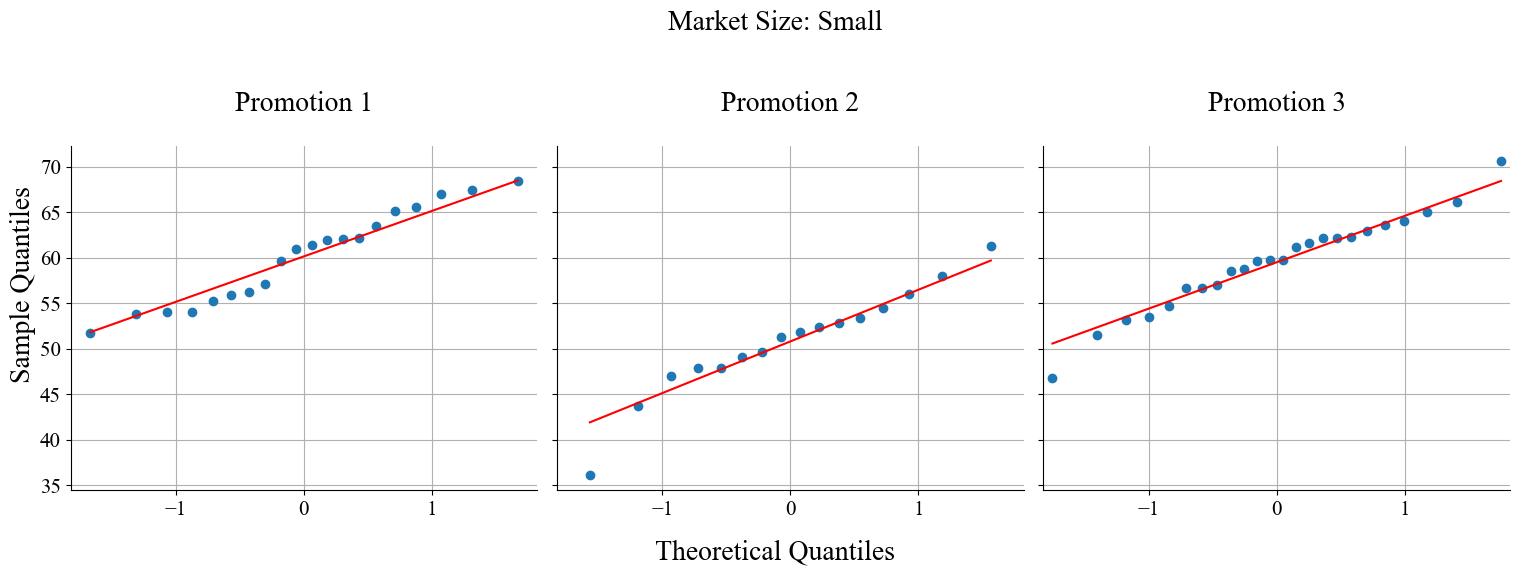

In [29]:
# Test for normality in each market size
normality_test(cleaned_data[cleaned_data['MarketSize'] == 'Large'], 'Large')
normality_test(cleaned_data[cleaned_data['MarketSize'] == 'Medium'], 'Medium')
normality_test(cleaned_data[cleaned_data['MarketSize'] == 'Small'], 'Small')

When we consider only **the small and medium market** data, the p-value in all cases is **above the 0.05** significance level. Therefore, \
we **fail to reject the null hypothesis** and conclude that the data is **normally distributed** in these two cases.
For the **large market** data, \
the p-values in all cases are **below the 0.05** significance level. Therefore, we **reject the null hypothesis** and conclude that the data is **not normally distributed**.

### 1.2 Levene test

We compute the Levene test to check the homogeneity of variances across groups for small and medium markets. 

In [ ]:
cons.print("Levene's Test for [bold]Medium[/bold]:")

levene_result_medium = levene(
    cleaned_data[(cleaned_data['MarketSize'] == 'Medium') & (cleaned_data['Promotion'] == 1)]['SalesInThousands'],
    cleaned_data[(cleaned_data['MarketSize'] == 'Medium') & (cleaned_data['Promotion'] == 2)]['SalesInThousands'],
    cleaned_data[(cleaned_data['MarketSize'] == 'Medium') & (cleaned_data['Promotion'] == 3)]['SalesInThousands']
)
print(levene_result_medium)

cons.print("Levene's Test for [bold]Small[/bold]:")
levene_result_small =levene(
    cleaned_data[(cleaned_data['MarketSize'] == 'Small') & (cleaned_data['Promotion'] == 1)]['SalesInThousands'],
    cleaned_data[(cleaned_data['MarketSize'] == 'Small') & (cleaned_data['Promotion'] == 2)]['SalesInThousands'],
    cleaned_data[(cleaned_data['MarketSize'] == 'Small') & (cleaned_data['Promotion'] == 3)]['SalesInThousands']
)
print(levene_result_small)

Levene's Test for Medium:

LeveneResult(statistic=0.6231509705329538, pvalue=0.5369097078714202)


Levene's Test for Small:

LeveneResult(statistic=0.06363402963211742, pvalue=0.9384149081167994)


Since the data appears to be normally distributed within small and medium market size, as indicated by the Shapiro-Wilk and \
Levene's test results, parametric tests can be used to compare the sales performance of the three promotions within these market size.

>​To summarise: 
>
>- The p-values for the **large markets** and **all markets** together, are **less than 0.05**, indicating that the data for each promotion **does not follow a normal distribution**. \
>As a result, the assumptions for **ANOVA are not fully met**, and a non-parametric test like the **Kruskal-Wallis test**, \
>which does not require normality, will be used instead.
>
>- For the **small and medium markets**, the **p-values are greater than 0.05**, indicating that the assumptions \
>for **ANOVA are fully met**. Therefore, the parametric test **ANOVA will be conducted** for these two cases.

#### 2. Statistical Tests to Compare Groups
Once the normality and homogeneity of variance assumptions have been assessed, we can proceed with statistical tests to determine whether the differences between the groups are significant.

- **If the Data is Normally Distributed**:
    - **ANOVA (Analysis of Variance)**: \
    ANOVA is used to compare the means of three or more groups and tests the following hypotheses: 
    - **Null Hypothesis (H<sub>0</sub>)**: The means of all groups are equal ($\mu$<sub>A</sub>=$\mu$<sub>B</sub>=$\mu$<sub>C</sub>). 
        - **Alternative Hypothesis (H<sub>1</sub>)**: At least one group has a different mean. 

If the ANOVA result is statistically significant (p-value < 0.05), it indicates that there are differences \
between groups. To identify which specific groups differ, post-hoc tests (e.g., Tukey’s HSD) are performed.

- **If the Data is Not Normally Distributed**:
    - **Kruskal-Wallis Test**: \
    The Kruskal-Wallis test is a non-parametric alternative to ANOVA that does not assume normality. \
    It tests whether the distributions of sales differ between groups.

        - **Null Hypothesis (H<sub>0</sub>)**: The distributions of sales are the same across groups.
        - **Alternative Hypothesis (H<sub>1</sub>)**: At least one group has a different distribution of sales. 
        
If the Kruskal-Wallis test result is significant (p-value < 0.05), conduct a post-hoc test such as the <br /> 
Dunn Test to identify which specific groups are different. The Dunn Test adjusts for multiple comparisons to control for Type I errors.

#### 2.1 ANOVA (Analysis of Variance) and Tukey’s HSD

#####  2.1.1 Medium market size

In [ ]:
print('ANOVA Test for Market Size: Medium')
f_oneway(
    cleaned_data[(cleaned_data['MarketSize'] == 'Medium') & (cleaned_data['Promotion'] == 1)]['SalesInThousands'],
    cleaned_data[(cleaned_data['MarketSize'] == 'Medium') & (cleaned_data['Promotion'] == 2)]['SalesInThousands'],
    cleaned_data[(cleaned_data['MarketSize'] == 'Medium') & (cleaned_data['Promotion'] == 3)]['SalesInThousands']
)

ANOVA Test for Market Size: Medium


F_onewayResult(statistic=28.537810901950035, pvalue=4.042530984776509e-12)

The **small p-value** strongly suggests that the observed differences in sales means across the three promotion types are **statistically significant**.


In [ ]:
print('Post-hoc Analysis for Market Size: Medium')
posthoc = pairwise_tukeyhsd(
    cleaned_data[(cleaned_data['MarketSize'] == 'Medium')]['SalesInThousands'],
    cleaned_data[(cleaned_data['MarketSize'] == 'Medium')]['Promotion']
)
posthoc_df = pd.DataFrame(data=posthoc.summary().data[1:], columns=posthoc.summary().data[0])
posthoc_df['p-adj'] = posthoc_df['p-adj'].apply(lambda x: f"{x:.2f}")
posthoc_df

Post-hoc Analysis for Market Size: Medium


,group1,group2,meandiff,p-adj,lower,upper,reject
0,1,2,-8.3548,0.00,-11.0874,-5.6221,True
1,1,3,-2.2037,0.13,-4.8858,0.4784,False
2,2,3,6.1510,0.00,3.5455,8.7566,True


In [ ]:
# Function to compute confidence interval for the difference between means
def compute_difference_confidence_interval(data1, data2, confidence=0.95):
    n1, n2 = len(data1), len(data2)
    mean1, mean2 = np.mean(data1), np.mean(data2)
    sem1, sem2 = stats.sem(data1), stats.sem(data2)  

    mean_diff = mean1 - mean2

    sed = np.sqrt(sem1**2 + sem2**2)

    margin_of_error = sed * stats.t.ppf((1 + confidence) / 2., min(n1, n2) - 1)

    return mean_diff, mean_diff - margin_of_error, mean_diff + margin_of_error

# Function to compare all promotions within a specified market size
def compare_promotions(market_size):
    promotions = cleaned_data['Promotion'].unique()
    results = []

    for i in range(len(promotions)):
        for j in range(i + 1, len(promotions)):
            promotion1 = promotions[i]
            promotion2 = promotions[j]

            sales_promotion_1 = cleaned_data[(cleaned_data['MarketSize'] == market_size) & (cleaned_data['Promotion'] == promotion1)]['SalesInThousands']
            sales_promotion_2 = cleaned_data[(cleaned_data['MarketSize'] == market_size) & (cleaned_data['Promotion'] == promotion2)]['SalesInThousands']

            mean_diff, lower_ci, upper_ci = compute_difference_confidence_interval(sales_promotion_1, sales_promotion_2)

            results.append({
                'Promotion1': promotion1,
                'Promotion2': promotion2,
                'Mean Difference': mean_diff,
                'Lower CI': lower_ci,
                'Upper CI': upper_ci
            })

    return results


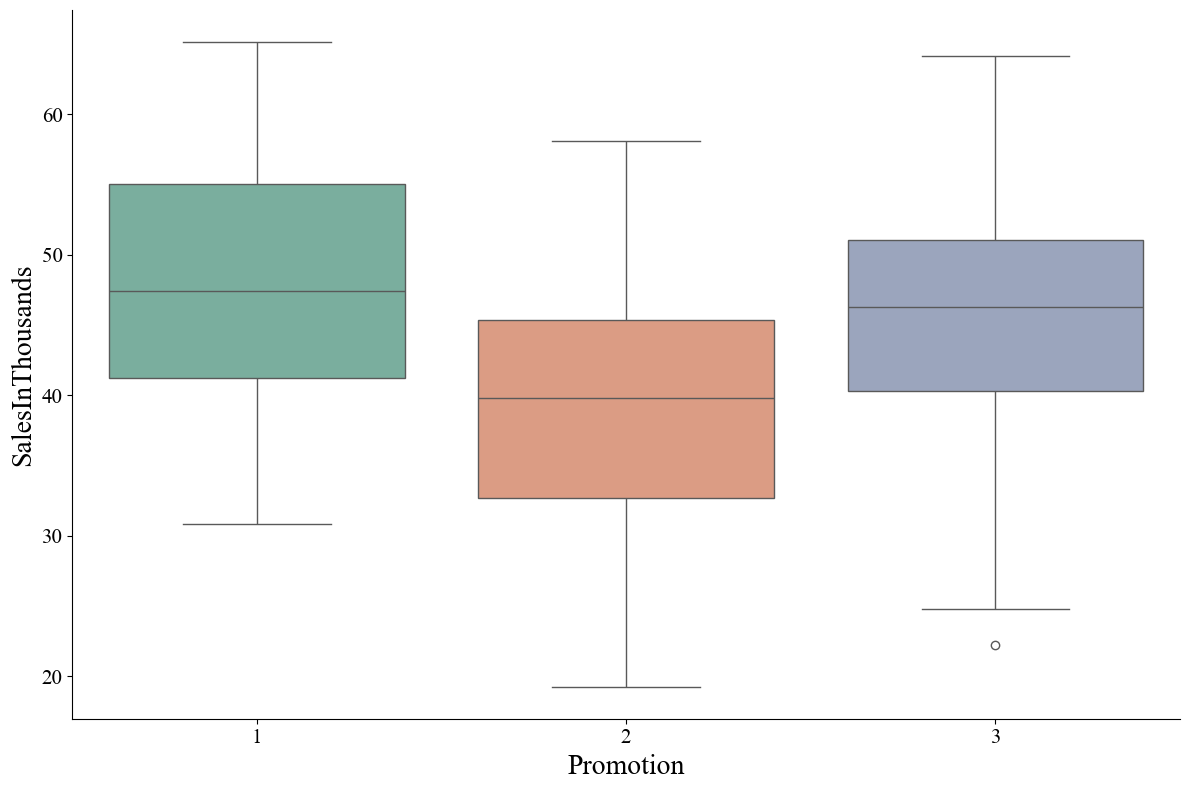

In [ ]:
# plot the boxplot for the small market size
plt.figure()
sns.boxplot(data=cleaned_data[cleaned_data['MarketSize'] == 'Medium'], x='Promotion', y='SalesInThousands', palette=custom_palette)
sns.despine()
plt.tick_params(axis='x', bottom=True, top=False)
plt.tick_params(axis='y', left=True, right=False)
plt.tight_layout()
plt.show()

In [ ]:
market_size = 'Medium'
comparison_results = compare_promotions(market_size)

for result in comparison_results:
    print(f"Promotion {result['Promotion1']} vs Promotion {result['Promotion2']}: Mean Difference = {result['Mean Difference']:.2f}, CI = ({result['Lower CI']:.2f}, {result['Upper CI']:.2f})")

Promotion 3 vs Promotion 2: Mean Difference = 6.15, CI = (3.93, 8.37)
Promotion 3 vs Promotion 1: Mean Difference = -2.20, CI = (-4.42, 0.01)
Promotion 2 vs Promotion 1: Mean Difference = -8.35, CI = (-10.68, -6.03)


Based on the values obtained, we can concluded that for **medium market** sizes:

- **Promotion 1 vs. Promotion 2**: Highly significant difference (p-value = 0.0)
- **Promotion 1 vs. Promotion 3**: No significant difference (p-value = 0.13)
- **Promotion 2 vs. Promotion 3**: Highly significant difference (p-value = 0.0)

In summary:

- There are **statistically significant differences** in sales between **Promotion 1 and Promotion 2**, and between **Promotion 2 and Promotion 3**.
- There is **no statistically significant difference** in sales between **Promotion 1 and Promotion 3**.

##### 2.1.2 Small market size

In [ ]:
print('ANOVA Test for Market Size: Small')
f_oneway(
    cleaned_data[(cleaned_data['MarketSize'] == 'Small') & (cleaned_data['Promotion'] == 1)]['SalesInThousands'],
    cleaned_data[(cleaned_data['MarketSize'] == 'Small') & (cleaned_data['Promotion'] == 2)]['SalesInThousands'],
    cleaned_data[(cleaned_data['MarketSize'] == 'Small') & (cleaned_data['Promotion'] == 3)]['SalesInThousands']
)

ANOVA Test for Market Size: Small


F_onewayResult(statistic=16.57648112557373, pvalue=2.115939995841426e-06)

Also in the small markets size, the **small p-value** strongly suggests that the observed differences in sales means across the three promotion types are **statistically significant**.

In [ ]:
print('Post-hoc Analysis for Market Size: Small')
posthoc = pairwise_tukeyhsd(
    cleaned_data[cleaned_data['MarketSize'] == 'Small']['SalesInThousands'],
    cleaned_data[cleaned_data['MarketSize'] == 'Small']['Promotion']
)
posthoc_df = pd.DataFrame(data=posthoc.summary().data[1:], columns=posthoc.summary().data[0])
posthoc_df['p-adj'] = posthoc_df['p-adj'].apply(lambda x: f"{x:.4f}")
posthoc_df

Post-hoc Analysis for Market Size: Small


,group1,group2,meandiff,p-adj,lower,upper,reject
0,1,2,-9.3519,0.0000,-13.6830,-5.0208,True
1,1,3,-0.6483,0.9161,-4.5579,3.2612,False
2,2,3,8.7035,0.0000,4.5359,12.8712,True


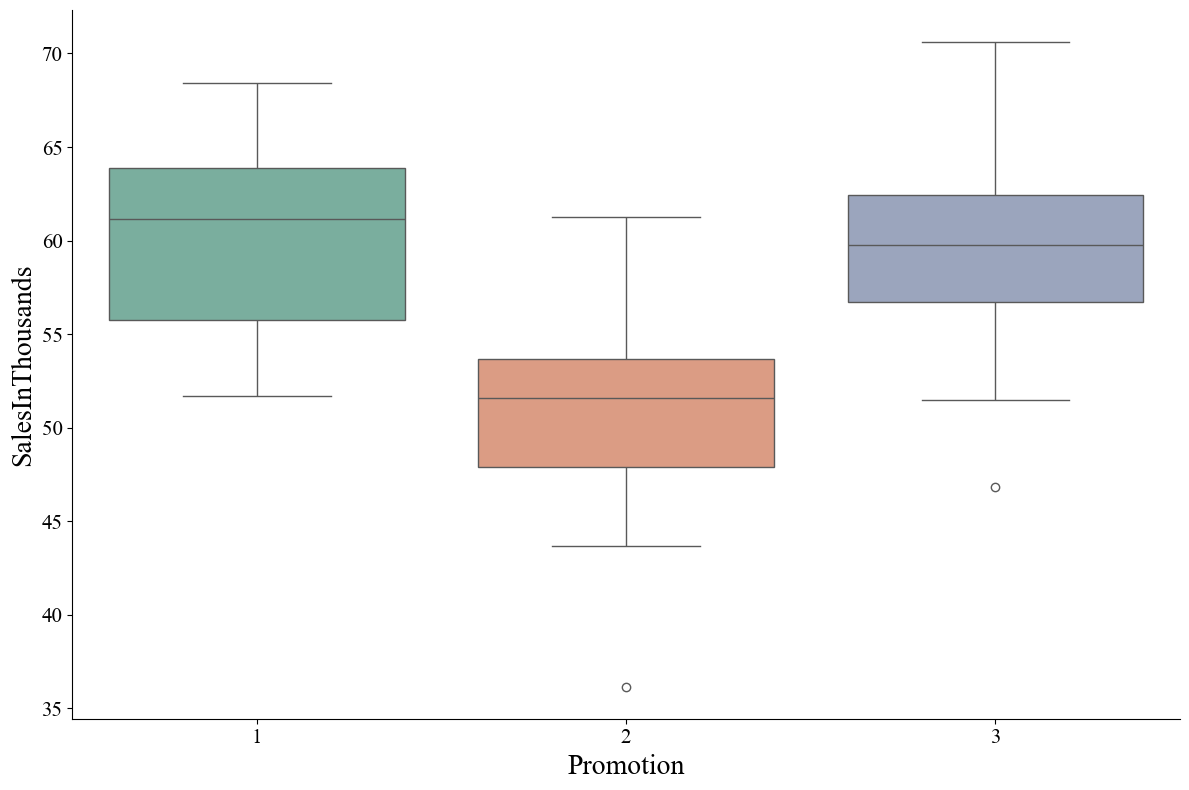

In [ ]:
# plot the boxplot for the small market size
plt.figure()
sns.boxplot(data=cleaned_data[cleaned_data['MarketSize'] == 'Small'], x='Promotion', y='SalesInThousands', palette=custom_palette)
sns.despine()
plt.tick_params(axis='x', bottom=True, top=False)
plt.tick_params(axis='y', left=True, right=False)
plt.tight_layout()
plt.show()

In [ ]:
market_size = 'Small'
comparison_results = compare_promotions(market_size)

for result in comparison_results:
    print(f"Promotion {result['Promotion1']} vs Promotion {result['Promotion2']}: Mean Difference = {result['Mean Difference']:.2f}, CI = ({result['Lower CI']:.2f}, {result['Upper CI']:.2f})")

Promotion 3 vs Promotion 2: Mean Difference = 8.70, CI = (4.84, 12.57)
Promotion 3 vs Promotion 1: Mean Difference = -0.65, CI = (-3.92, 2.63)
Promotion 2 vs Promotion 1: Mean Difference = -9.35, CI = (-13.32, -5.38)


Based on the values obtained, we can concluded that for **small market** sizes:

- **Promotion 1 vs. Promotion 2**: Highly significant difference (p-value = 0.0)
- **Promotion 1 vs. Promotion 3**: No significant difference (p-value = 0.91)
- **Promotion 2 vs. Promotion 3**: Highly significant difference (p-value = 0.0)

In summary, we reach the same conclusions for small markets as we do for medium markets.

- There are **statistically significant differences** in sales between **Promotion 1 and Promotion 2**, and between **Promotion 2 and Promotion 3**.
- There is **no statistically significant difference** in sales between **Promotion 1 and Promotion 3**.

#### 2.2 Kruskal-Wallis and Dunn test

##### 2.2.1 Large market sizes

In [ ]:
def kruskal_test(df, size):
    print('Market Size: ' + size + '\nResults: ' + str(
    kruskal(df[df['Promotion']==1]['SalesInThousands'], 
                df[df['Promotion']==2]['SalesInThousands'], 
                df[df['Promotion']==3]['SalesInThousands'])))

In [ ]:
print('Market size: Large' + '\nResults: ' + str(
    kruskal(
        cleaned_data[(cleaned_data['MarketSize'] == 'Large') & (cleaned_data['Promotion'] == 1)]['SalesInThousands'],
        cleaned_data[(cleaned_data['MarketSize'] == 'Large') & (cleaned_data['Promotion'] == 2)]['SalesInThousands'],
        cleaned_data[(cleaned_data['MarketSize'] == 'Large') & (cleaned_data['Promotion'] == 3)]['SalesInThousands']
    )
))

Market size: Large
Results: KruskalResult(statistic=64.2305930990447, pvalue=1.1285061335482766e-14)


The p-value in large markets is **less than 0.05**. Hence the **null hypothesis is rejected**. Therefore, \
we can conclude that, also in this case, there is at least one pair of promotions that have a statistical difference of means in each market size.

In [ ]:
def dunns_test (df = df): 
    group=[]
    for a in range(1,4):
        promotion_a = df[df['Promotion'] == a]['SalesInThousands']
        group.append(promotion_a)
        a+=1
    return posthoc_dunn(group, p_adjust = 'bonferroni')

In [ ]:
dunns_test(df = df[df['MarketSize'] == 'Large'])

,1,2,3
1,1.000000e+00,1.509844e-07,1.000000e+00
2,1.509844e-07,1.000000e+00,1.533086e-07
3,1.000000e+00,1.533086e-07,1.000000e+00


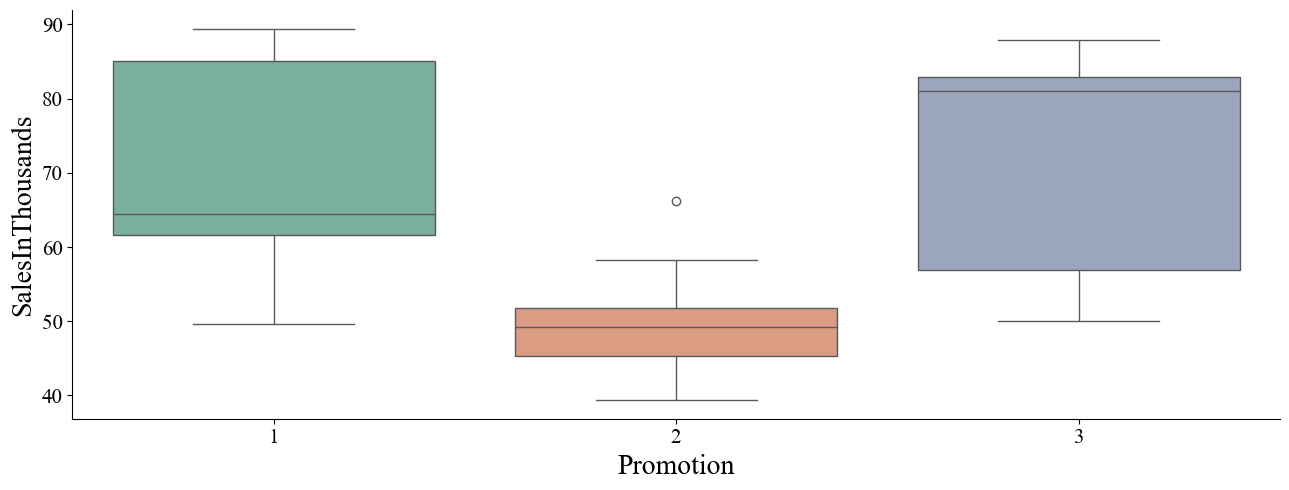

In [ ]:
# plot the boxplot for the large market size
plt.figure(figsize=(13, 5))
sns.boxplot(data=cleaned_data[cleaned_data['MarketSize'] == 'Large'], x='Promotion', y='SalesInThousands', palette=custom_palette)
sns.despine()
plt.tick_params(axis='x', bottom=True, top=False)
plt.tick_params(axis='y', left=True, right=False)
plt.tight_layout()
plt.show()

In [ ]:
market_size = 'Large'
comparison_results = compare_promotions(market_size)

for result in comparison_results:
    print(f"Promotion {result['Promotion1']} vs Promotion {result['Promotion2']}: Mean Difference = {result['Mean Difference']:.2f}, CI = ({result['Lower CI']:.2f}, {result['Upper CI']:.2f})")

Promotion 3 vs Promotion 2: Mean Difference = 24.09, CI = (19.33, 28.85)
Promotion 3 vs Promotion 1: Mean Difference = 3.38, CI = (-2.61, 9.36)
Promotion 2 vs Promotion 1: Mean Difference = -20.71, CI = (-24.99, -16.43)


Also for **Large market**, we can concluded that:

- **Promotion 1 vs. Promotion 2**: Highly significant difference (p-value = 0.0)
- **Promotion 1 vs. Promotion 3**: No significant difference (p-value = 1.0)
- **Promotion 2 vs. Promotion 3**: Highly significant difference (p-value = 0.0)

In summary, we can draw the same conclusion for large markets as we did for medium and small markets.

- There are **statistically significant differences** in sales between **Promotion 1 and Promotion 2**, and between **Promotion 2 and Promotion 3**.
- There is **no statistically significant difference** in sales between **Promotion 1 and Promotion 3**.

##### 2.2.2 All markets regardless the size

In [ ]:
print('All market size' + '\nResults: ' + str(
    kruskal(
        cleaned_data[cleaned_data['Promotion'] == 1]['SalesInThousands'],
        cleaned_data[cleaned_data['Promotion'] == 2]['SalesInThousands'],
        cleaned_data[cleaned_data['Promotion'] == 3]['SalesInThousands']
    )
))

All market size
Results: KruskalResult(statistic=80.06537463352375, pvalue=4.111732025490055e-18)


The p-value in all markets considered together is **less than 0.05**. Hence the **null hypothesis is rejected**. 


In [ ]:
dunns_test(df = df)

,1,2,3
1,1.000000e+00,6.461842e-12,1.458660e-01
2,6.461842e-12,1.000000e+00,7.083069e-07
3,1.458660e-01,7.083069e-07,1.000000e+00


In [ ]:
def compare_promotions_entire_dataset():
    promotions = cleaned_data['Promotion'].unique()
    results = []

    for i in range(len(promotions)):
        for j in range(i + 1, len(promotions)):
            promotion1 = promotions[i]
            promotion2 = promotions[j]

            sales_promotion_1 = cleaned_data[cleaned_data['Promotion'] == promotion1]['SalesInThousands']
            sales_promotion_2 = cleaned_data[cleaned_data['Promotion'] == promotion2]['SalesInThousands']

            mean_diff, lower_ci, upper_ci = compute_difference_confidence_interval(sales_promotion_1, sales_promotion_2)

            results.append({
                'Promotion1': promotion1,
                'Promotion2': promotion2,
                'Mean Difference': mean_diff,
                'Lower CI': lower_ci,
                'Upper CI': upper_ci
            })

    return results

comparison_results = compare_promotions_entire_dataset()

for result in comparison_results:
    print(f"Promotion {result['Promotion1']} vs Promotion {result['Promotion2']}: Mean Difference = {result['Mean Difference']:.2f}, CI = ({result['Lower CI']:.2f}, {result['Upper CI']:.2f})")

    

Promotion 3 vs Promotion 2: Mean Difference = 10.39, CI = (7.81, 12.98)
Promotion 3 vs Promotion 1: Mean Difference = -2.05, CI = (-5.09, 0.99)
Promotion 2 vs Promotion 1: Mean Difference = -12.44, CI = (-14.98, -9.90)


Again, for **all markets regardless the size**, we can concluded that:

- **Promotion 1 vs. Promotion 2**: Highly significant difference (p-value = 0.0)
- **Promotion 1 vs. Promotion 3**: No significant difference (p-value = 0.14)
- **Promotion 2 vs. Promotion 3**: Highly significant difference (p-value = 0.0)

In summary, we can draw the same conclusion for all markets.

- There are **statistically significant differences** in sales between **Promotion 1 and Promotion 2**, and between **Promotion 2 and Promotion 3**.
- There is **no statistically significant difference** in sales between **Promotion 1 and Promotion 3**.

#### **Conclusions**:

In all the tests (all market sized together and market size separately) we got the same result.

- For **Promotion 1 vs Promotion 2** the *null hypothesis is rejected*.
- For **Promotion 1 vs Promotion 3** the *null hypothesis is accepted*.
- For **Promotion 2 vs Promotion 3** the *null hypothesis is rejected*.

That being said, we now have enough statistical arguments to say that:

We can expect **higher sales with promotions 1 and 3 than with promotion 2**.